# Low-dimensional Analyzers

@[Chaoming Wang](https://github.com/chaoming0625)

We have talked about model [simulation](../tutorial_simulation/index.rst) and [training](../tutorial_training/index.rst) for dynamical systems with BrainPy. In this tutorial, we are going to dive into how to perform automatic analysis for your defined systems.  

As is known to us all, dynamics analysis is necessary in neurodynamics. This is because blind simulation of nonlinear systems is likely to produce few results or misleading results. BrainPy has well supports for low-dimensional systems, no matter how nonlinear your defined system is. Specifically, BrainPy provides the following methods for the analysis of low-dimensional systems:

1. phase plane analysis;
2. codimension 1 or codimension 2 bifurcation analysis;
3. bifurcation analysis of the fast-slow system. 

BrainPy will help you probe the dynamical mechanism of your defined systems rapidly. 

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.enable_x64()  # It's better to enable x64 when performing analysis
bm.set_platform('cpu')

bp.__version__

'2.4.0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## A simple case

Here we test BrainPy with a simple case:

$$
\frac{dx}{dt} = \mathrm{sin}(x) + I,
$$

where $x \in [-10, 10]$.

As known to us all, this function has multiple fixed points ($\frac{dx}{dt} = 0$) when $I=0$.

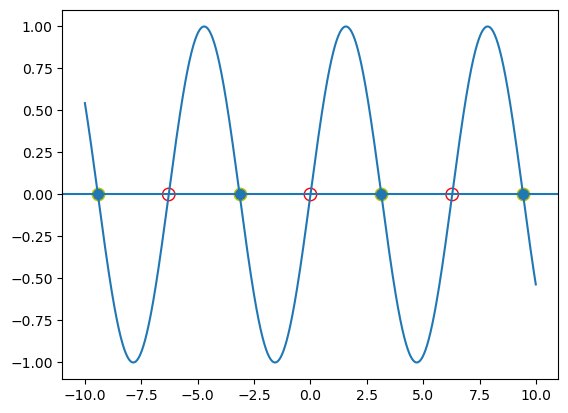

In [3]:
xs = np.arange(-10, 10, 0.01)

plt.plot(xs, np.sin(xs))
plt.scatter([-3*np.pi, -1*np.pi, 1*np.pi, 3 * np.pi], np.zeros(4), s=80, edgecolors='y')
plt.scatter([-2*np.pi, 0, 2*np.pi], np.zeros(3), s=80, facecolors='none', edgecolors='r')
plt.axhline(0)
plt.show()

According to the dynamical theory, at the red hollow points, they are unstable; and for the solid ones, they are stable points. 

Now let's come back to BrainPy, and test whether BrainPy can give us the right answer. 

As the analysis interfaces in BrainPy only receives [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst) or instance of [DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst), we first define an integrator with BrainPy (if you want to know how to define an ODE integrator, please refer to the tutorial of [Numerical Solvers for ODEs](../tutorial_intg/ode_numerical_solvers.ipynb)):

In [4]:
@bp.odeint
def int_x(x, t, Iext):
    return bp.math.sin(x) + Iext

This is a one-dimensional dynamical system. So we are trying to use [brainpy.analysis.PhasePlane1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane1D.rst) for phase plane analysis. The usage of phase plane analysis  will be detailed in the following section. Now, we just focus on the following four arguments:

- **model**: It specifies the target system to analyze. It can be a list/tuple of [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst). However, it can also be an instance of [DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst). For ``DynamicalSystem`` argument, we will use ``model.ints().subset(bp.ode.ODEIntegrator)`` to retrieve all instances of ODEIntegrator later. 
- **target_vars**: It specifies the variables to analyze. It must be a dict with the format of ``<var_name, var_interval>``, where ``var_name`` is the variable name, and ``var_interval`` is the boundary of this variable. 
- **pars_update**: Parameters to update. 
- **resolutions**: The resolution to evaluate the fixed points. 

Let's try it.

I am creating the vector field ...
I am searching fixed points ...
Fixed point #1 at x=-9.424777960769386 is a stable point.
Fixed point #2 at x=-6.283185307179586 is a unstable point.
Fixed point #3 at x=-3.1415926535897984 is a stable point.
Fixed point #4 at x=3.552755127361717e-18 is a unstable point.
Fixed point #5 at x=3.1415926535897984 is a stable point.
Fixed point #6 at x=6.283185307179586 is a unstable point.
Fixed point #7 at x=9.424777960769386 is a stable point.


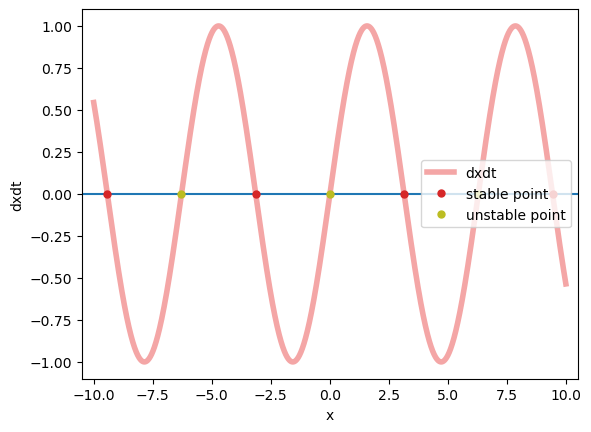

In [5]:
pp = bp.analysis.PhasePlane1D(
  model=int_x,
  target_vars={'x': [-10, 10]},
  pars_update={'Iext': 0.},
  resolutions={'x': 0.01}
)
pp.plot_vector_field()
pp.plot_fixed_point(show=True)

Yeah, absolutelty, ``brainpy.analysis.PhasePlane1D`` gives us the right fixed points, and correctly evaluates the stability of these fixed points.

Phase plane is important, because it gives us the intuitive understanding how the system evolves with the given parameters. However, in most cases where we care about how the parameters affect the system behaviors, we should make bifurcation analysis. [brainpy.analysis.Bifurcation1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.Bifurcation1D.rst) is a convenient interface to help you get the insights of how the dynamics of a 1D system changes with parameters.

Similar to ``brainpy.analysis.PhasePlane1D``, ``brainpy.analysis.Bifurcation1D`` receives arguments like "model", "target_vars", "pars_update", and "resolutions". Besides, one more important argument **"target_pars"** should be provided, which specifies the range of the target parameter in bifurcation analysis.

Here, we systematically change the parameter "Iext" from 0 to 1.5. According to the bifurcation theory, we know this simple system has a fold bifurcation when $I=1.0$. Because at $I=1.0$, two fixed points collide with each other into a saddle point and then disappear. Does BrainPy's analysis toolkit ``brainpy.analysis.Bifurcation1D`` is capable of performing these analyses? Let's make a try.

I am making bifurcation analysis ...


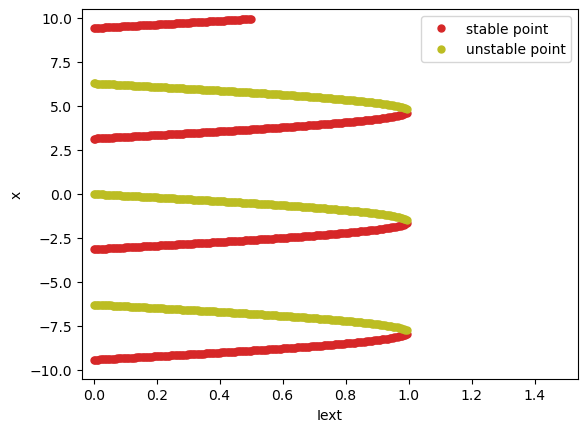

In [6]:
bif = bp.analysis.Bifurcation1D(
    model=int_x,
    target_vars={'x': [-10, 10]},
    target_pars={'Iext': [0., 1.5]},
    resolutions={'Iext': 0.005, 'x': 0.05}
)
bif.plot_bifurcation(show=True)

Once again, BrainPy analysis toolkit gives the right answer. It tells us how does the fixed points evolve when the parameter $I$ is increasing. 

It is worthy to note that bifurcation analysis in BrainPy is hard to find out the saddle point (when $I=0$ for this system). This is because the saddle point at the bifurcation just exists at a moment. While the numerical method used in BrainPy analysis toolkit is almost impossible to evaluate the point exactly at the saddle. However, if the user has the minimal knowledge about the bifurcation theory, saddle point (the collision point of two fixed points) can be easily inferred from the fixed point evolution.

BrainPy's analysis toolkit is highly useful, especially when the mathematical equations are too complex to get analytical solutions. The example please refer to the tutorial [Anlysis of A Decision Making Model](./decision_making_model.ipynb). 

## Phase plane analysis

Phase plane analysis is one of the most important techniques for studying the behavior of nonlinear systems, since there is usually no analytical solution for a nonlinear system. BrainPy can help users to plot phase plane of 1D systems or 2D systems. Specifically, we provide [brainpy.analysis.PhasePlane1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane1D.rst) and [brainpy.analysis.PhasePlane2D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane2D.rst). It can help to plot:

- **Nullcline**: The zero-growth isoclines, such as $g(x, y)=0$ and $g(x, y)=0$.
- **Fixed points**: The equilibrium points of the system, which are located at all the nullclines intersect.
- **Vector field**: The vector field of the system.
- **Limit cycles**: The limit cycles.
- **Trajectories**: A simulation trajectory with the given initial values.

We have talked about ``brainpy.analysis.PhasePlane1D`` in above. Now we focus on ``brainpy.analysis.PhasePlane2D`` by using a well-known neuron model FitzHugh-Nagumo model. 

The FitzHugh-Nagumo model is given by:

$$ 
\frac {dV} {dt} = V(1 - \frac {V^2} 3) - w + I_{ext} \\
\tau \frac {dw} {dt} = V + a - b w 
$$

There are two variables $V$ and $w$, so this is a two-dimensional system with three parameters $a, b$ and $\tau$.

For the system to analyze, users can define it by using the pure ``brainpy.odeint`` or define it as a class of ``DynamicalSystem``. For this FitzHugh-Nagumo model, we define it as a class because later we will perform simulation to verify the analysis results. 

In [7]:
class FitzHughNagumoModel(bp.DynamicalSystem):
  def __init__(self, method='exp_auto'):
    super(FitzHughNagumoModel, self).__init__()

    # parameters
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5

    # variables
    self.V = bm.Variable(bm.zeros(1))
    self.w = bm.Variable(bm.zeros(1))
    self.Iext = bm.Variable(bm.zeros(1))

    # functions
    def dV(V, t, w, Iext=0.): 
        return V - V * V * V / 3 - w + Iext
    def dw(w, t, V, a=0.7, b=0.8): 
        return (V + a - b * w) / self.tau
    self.int_V = bp.odeint(dV, method=method)
    self.int_w = bp.odeint(dw, method=method)

  def update(self, tdi):
    self.V.value = self.int_V(self.V, tdi.t, self.w, self.Iext, tdi.dt)
    self.w.value = self.int_w(self.w, tdi.t, self.V, self.a, self.b, tdi.dt)
    self.Iext[:] = 0.

In [8]:
model = FitzHughNagumoModel()

Here we perform a phase plane analysis with parameters $a=0.7, b=0.8, \tau=12.5$, and input $I_{ext} = 0.8$.

In [9]:
pp = bp.analysis.PhasePlane2D(
  model,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'Iext': 0.8}, 
  resolutions={'V': 0.01, 'w': 0.01},
)

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am creating the vector field ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 866 candidates
I am trying to filter out duplicate fixed points ...
	Found 1 fixed points.
	#1 V=-0.2729223248464073, w=0.5338542697673022 is a unstable node.
I am plotting the trajectory ...


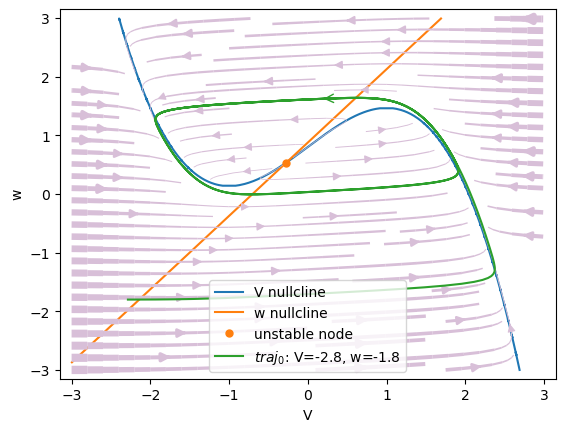

In [10]:
# By defaut, nullclines will be plotted as points, 
# while we can set the plot style as the line
pp.plot_nullcline(x_style={'fmt': '-'}, y_style={'fmt': '-'})

# Vector field can plotted as two ways:
# - plot_method="streamplot" (default)
# - plot_method="quiver"
pp.plot_vector_field()

# There are many ways to search fixed points. 
# By default, it will use the nullcline points of the first 
# variable ("V") as the initial points to perform fixed point searching
pp.plot_fixed_point()

# Trajectory plotting receives the setting of the initial points.
# There may be multiple trajectories, therefore the initial points 
# should be provived as a list/tuple/numpy.ndarray/Array
pp.plot_trajectory({'V': [-2.8], 'w': [-1.8]}, duration=100.)

# show the phase plane figure
pp.show_figure()

We can see an unstable-node at the point ($V=-0.27, w=0.53$) inside a limit cycle. 

We can run a simulation with the same parameters and initial values to verify the periodic activity that correspond to the limit cycle.

  0%|          | 0/1000 [00:00<?, ?it/s]

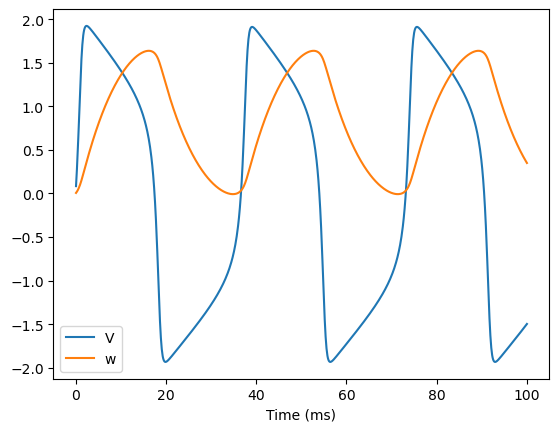

In [11]:
runner = bp.DSRunner(model, monitors=['V', 'w'], inputs=['Iext', 0.8])
runner.run(100.)

bp.visualize.line_plot(runner.mon.ts, runner.mon.V, legend='V')
bp.visualize.line_plot(runner.mon.ts, runner.mon.w, legend='w', show=True)

## Understanding settings

There are several key settings needed to understand. 

### ``resolutions``

``resolutions`` is one of the most important parameters in PhasePlane and Bifurcation analysis toolkits of BrainPy. It is very important because it has a profound impact on the efficiency of model analysis. 

We can set ``resolutions`` with the following ways.

1. **None**. If we detect there is no resolution setting for any variable, the corresponding resolution for this variable will be $\frac{\mathrm{max\_value} - \mathrm{min\_value}}{20}$.
2. **A float**. It sets a same resolution for each target variable and parameter. 
3. **A dict**. Specify different resolutions for individual variable/parameter. It can be a *float*, or a vector with the format of *Array* or *numpy.ndarray*. 

```{Note}
It is highly recommended that users specify the resolution to specific parameters or variables by a dict rather than set a float value, which will be applied to all variables. Otherwise, the computation will occupy too much memory if the resolution is set very small. For example, if you want to set the resolution of variable `x` as 0.01, please use `resolutions={'x': 0.01}`.
```

Enabling set ``resolutions`` with a tensor will give the user the maximal flexibility. Usually, the numerical analysis does not work well at inflection points. Therefore, we can increase the granularity near the inflection points. For example, if there is an inflection point at $1$, we can set the resolution with:

In [12]:
r1 = bm.arange(0.00, 0.95, 0.01)
r2 = bm.arange(0.95, 1.01, 0.001)
r3 = bm.arange(1.05, 1.50, 0.01)
resolution = bm.concatenate([r1, r2, r3])

**Tips**: For bifurcation analysis, usually we need set a small resolution for parameters, leaving the resolutions of variables as the default. Please see in the following examples.

### ``vars`` and ``pars``

What can be set as variables ``*_vars`` or parameters ``*_pars`` (such as ``target_vars`` or ``target_pars``) for further analysis? Actually, the variables and parameters are recognized as the same with the programming paradigm of [ODE numerical integrators](../tutorial_intg/ode_numerical_solvers.ipynb). Simply speaking, the arguments before ``t`` will be defined as variables, while arguments after ``t`` will be parameters.  

BrainPy's analysis toolkit only support one variable in one differential equation. It cannot analyze the joint differential equation in which multiple variables are defined in the same function. 

Moreover, the low-dimensional analyzers in BrainPy cannot analyze dynamical system depends on time $t$.

## Bifurcation analysis

Nonlinear dynamical systems are characterized by its parameters. When the parameter changes, the system's behavior will change qualitatively. Therefore, we take care of how the system changes with the smooth change of parameters. 

**Codimension 1 bifurcation analysis**

We will first see the codimension 1 bifurcation analysis of the model. For example, we vary the input $I_{ext}$ between 0 and 1 and see how the system change its stability.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 5000 candidates
I am trying to filter out duplicate fixed points ...
	Found 500 fixed points.


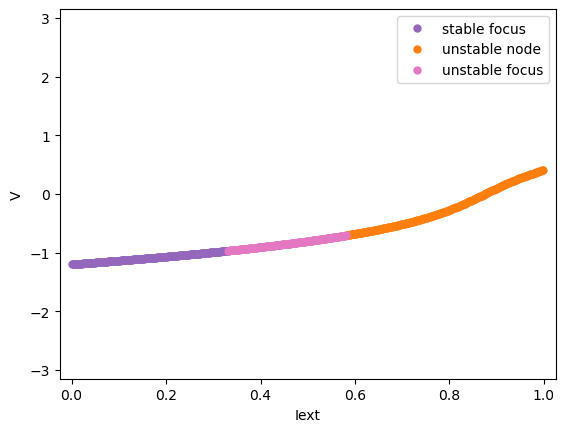

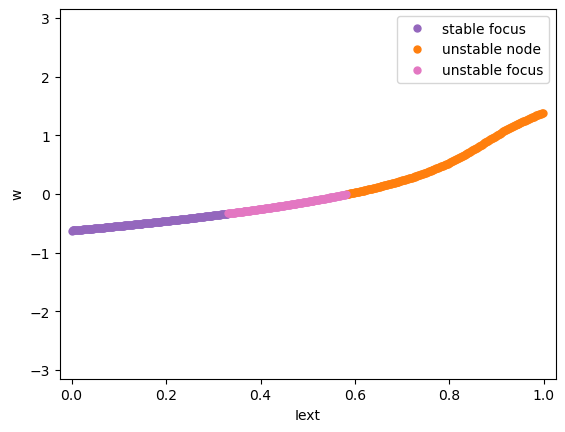

In [13]:
analyzer = bp.analysis.Bifurcation2D(
  model,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  target_pars={'Iext': [0., 1.]},
  resolutions={'Iext': 0.002},
)

# "num_rank" specifies the number of initial poinits for
# fixed point optimization under a set of parameters
analyzer.plot_bifurcation(num_rank=10)

# show figure
analyzer.show_figure()

**Codimension 2 bifurcation analysis**

We simulaneously change $I_{ext}$ and parameter $a$.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 50000 candidates
I am trying to filter out duplicate fixed points ...
	Found 4997 fixed points.


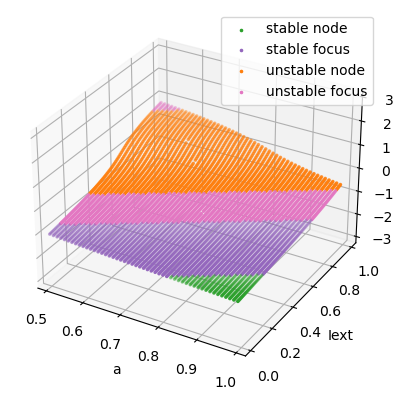

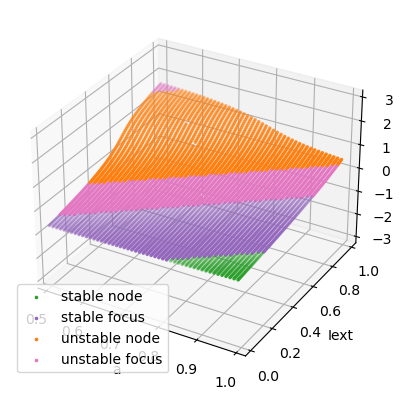

In [14]:
analyzer = bp.analysis.Bifurcation2D(
    model,
    target_vars=dict(V=[-3, 3], w=[-3., 3.]),
    target_pars=dict(a=[0.5, 1.], Iext=[0., 1.]),
    resolutions={'a': 0.01, 'Iext': 0.01},
)
analyzer.plot_bifurcation(num_rank=10, tol_aux=1e-9)
analyzer.show_figure()

## Fast-slow system bifurcation

BrainPy also provides a tool for fast-slow system bifurcation analysis by using [brainpy.analysis.FastSlow1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.FastSlow1D.rst) and [brainpy.analysis.FastSlow2D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.FastSlow2D.rst). This method is proposed by John Rinzel [1, 2, 3]. (J Rinzel, 1985, 1986, 1987) proposed that in a fast-slow dynamical system, we can treat the slow variables as the bifurcation parameters, and then study how the different value of slow variables affect the bifurcation of the fast sub-system.


Fast-slow bifurcation methods are very useful in the bursting neuron analysis. I will illustrate this by using the Hindmarsh-Rose model. The Hindmarsh–Rose model of neuronal activity is aimed to study the spiking-bursting behavior of the membrane potential observed in experiments made with a single neuron. Its dynamics are governed by:

$$
\begin{aligned}
\frac{d V}{d t} &= y - a V^3 + b V^2 - z + I\\
\frac{d y}{d t} &= c - d V^2 - y\\
\frac{d z}{d t} &= r (s (V - V_{rest}) - z)
\end{aligned}
$$

First, let's define the Hindmarsh–Rose model with BrainPy.

In [15]:
a = 1.
b = 3.
c = 1.
d = 5.
s = 4.
x_r = -1.6
r = 0.001
Vth = 1.9


@bp.odeint
def int_x(x, t, y, z, Isyn):
    return y - a * x ** 3 + b * x * x - z + Isyn

@bp.odeint
def int_y(y, t, x):
    return c - d * x * x - y

@bp.odeint
def int_z(z, t, x):
    return r * (s * (x - x_r) - z)

We now can start to analysis the underlying bifurcation mechanism.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 20000 candidates
I am trying to filter out duplicate fixed points ...
	Found 1156 fixed points.


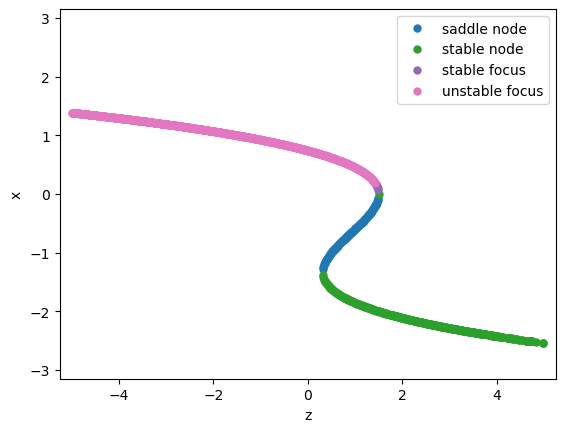

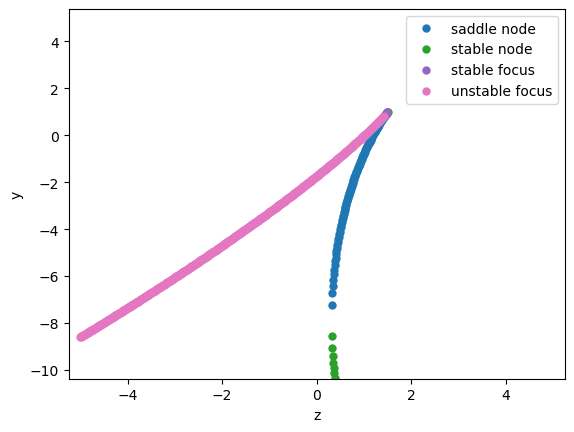

In [16]:
analyzer = bp.analysis.FastSlow2D(
  [int_x, int_y, int_z],
  fast_vars={'x': [-3, 3], 'y': [-10., 5.]},
  slow_vars={'z': [-5., 5.]},
  pars_update={'Isyn': 0.5},
  resolutions={'z': 0.01}
)
analyzer.plot_bifurcation(num_rank=20)
analyzer.show_figure()

## References

[1] Rinzel, John. "Bursting oscillations in an excitable membrane model." In Ordinary and partial differential  equations, pp. 304-316. Springer, Berlin, Heidelberg, 1985.
           
[2] Rinzel, John , and Y. S. Lee . On Different Mechanisms for Membrane Potential Bursting. Nonlinear Oscillations in Biology and Chemistry. Springer Berlin Heidelberg, 1986.

[3] Rinzel, John. "A formal classification of bursting mechanisms in excitable systems." In Mathematical topics in population biology, morphogenesis and neurosciences, pp. 267-281. Springer, Berlin, Heidelberg, 1987.
